In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
# first, before we do anything, let's look/listen at some data.
# understand what we are interested in
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"

y, sr = librosa.load(audio_file_path, duration=10)
# hi alex
ipd.Audio(y, rate=sr)

In [3]:
# S, n_fft = _spectrogram(
#     y=y,
#     S=S,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     power=2,
#     win_length=win_length,
#     window=window,
#     center=center,
#     pad_mode=pad_mode,
# )

# spectrogram = librosa.stft(y)

# D_harmonic, D_percussive = librosa.decompose.hpss(spectrogram)

# if tuning is None:
#     tuning = estimate_tuning(S=S, sr=sr, bins_per_octave=n_chroma)

# # Get the filter bank
# chromafb = filters.chroma(
#     sr=sr, n_fft=n_fft, tuning=tuning, n_chroma=n_chroma, **kwargs
# )

# # Compute raw chroma
# raw_chroma = np.einsum("cf,...ft->...ct", chromafb, S, optimize=True)

# # Compute normalization factor for each frame
# util.normalize(raw_chroma, norm=norm, axis=-2)

### harmonic percussive source separation of gamelan instruments (median filtering)

- you might want to have a look at this (https://librosa.org/librosa_gallery/auto_examples/plot_hprss.html)
- note that librosa is already applying wiener masking
- consider tweaking margin and kernel parameters of _librosa.decompose.hpss()_


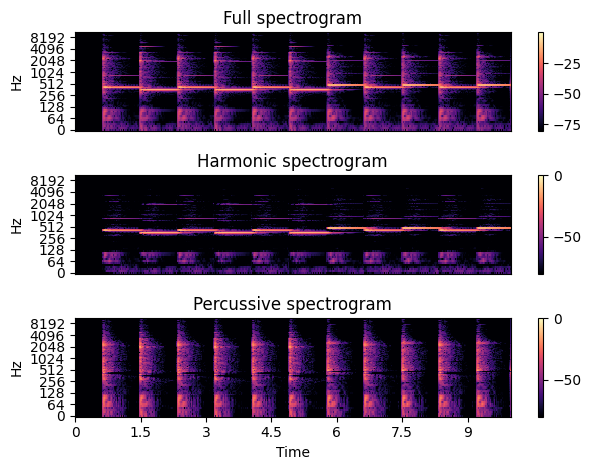

In [4]:
spectrogram = librosa.stft(y)

D_harmonic, D_percussive = librosa.decompose.hpss(spectrogram)

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

### Non negative matrix factorization

https://librosa.org/doc/0.10.1/generated/librosa.decompose.decompose.html#librosa.decompose.decompose

- idea: the init of H for the NNMF can help us catch the right pitches for gamelan


In [ ]:
comps, acts = librosa.decompose.decompose(np.abs(spectrogram))

layout = [list(".AAAA"), list("BCCCC"), list(".DDDD")]

fig, ax = plt.subplot_mosaic(layout, constrained_layout=True)

librosa.display.specshow(
    librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log", x_axis="time", ax=ax["A"]
)
ax["A"].set(title="Input spectrogram")
ax["A"].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max), y_axis="log", ax=ax["B"])
ax["B"].set(title="Components")
ax["B"].label_outer()
ax["B"].sharey(ax["A"])

librosa.display.specshow(acts, x_axis="time", ax=ax["C"], cmap="gray_r")
ax["C"].set(ylabel="Components", title="Activations")
ax["C"].sharex(ax["A"])
ax["C"].label_outer()


S_approx = comps.dot(acts)
img = librosa.display.specshow(
    librosa.amplitude_to_db(S_approx, ref=np.max), y_axis="log", x_axis="time", ax=ax["D"]
)

ax["D"].set(title="Reconstructed spectrogram")
ax["D"].sharex(ax["A"])
ax["D"].sharey(ax["A"])
ax["D"].label_outer()

fig.colorbar(img, ax=list(ax.values()), format="%+2.f dB")

# Fundamental Frequency Tracking

In [5]:
y, sr = librosa.load(audio_file_path, duration=10)
ipd.Audio(y, rate=sr)

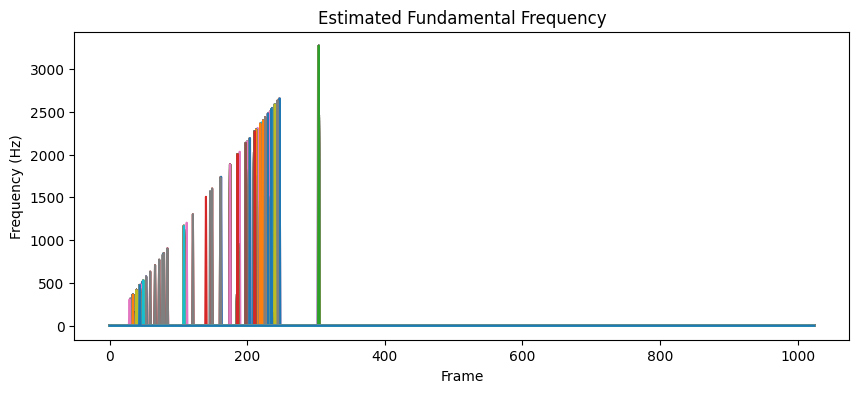

In [6]:
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

plt.figure(figsize=(10, 4))
plt.plot(pitches)
plt.xlabel('Frame')
plt.ylabel('Frequency (Hz)')
plt.title('Estimated Fundamental Frequency')
plt.show()
